#### Library

This is the same set of functions that I used in assignment 1, with some improvements that will allow for more intuitive plotting

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML # This function is only for visualisation.

last_method = None
method_params = None
def step(i,t,x,dydt,method,dt):
    global last_method, method_params
    if method=="Euler":
        k1 = dydt(t[i],x[i])*dt
        last_method = method
        return x[i] + k1
    elif method=="RK2":
        k1 = dydt(t[i],x[i])*dt
        k2 = dydt(t[i]+dt,x[i]+k1)*dt
        last_method = method
        return x[i] + (k1+k2)/2
    elif method.startswith("RK2("):
        if method == last_method:
            a1,a2,p,q = method_params
        else:
            params = method[4:-1].strip().split(",")
            ARGS = []
            KWARGS = {"a1":None,"a2":None,"p":None,"q":None}
            for x in params:
                if "=" in x :
                    P,V = x.split("=")
                    KWARGS[P.strip().lower()] = float(V)
                else:
                    ARGS.append(float(x))
            ARGS = ARGS[::-1]
            for x in KWARGS:
                if KWARGS[x] is None:
                    KWARGS[x] = ARGS.pop()
            if KWARGS["a2"] is None: a2 = 1 - a1
            else: a2 = KWARGS["a2"]
            if KWARGS["a1"] is None: a1 = 1 - a2
            else: a1 = KWARGS["a1"]
            if KWARGS["p"] is None: p = 1/(2*a2)
            else: p = KWARGS["p"]
            if KWARGS["q"] is None: q = 1/(2*a2)
            else: q = KWARGS["q"]
            last_method = method
            method_params = (a1,a2,p,q)

        k1 = dydt(t[i],x[i])*dt
        k2 = dydt(t[i]+(p*dt), x[i]+(k1*q*dt))*dt
        return x[i] + (a1*k1 + a2*k2)

    elif method == "EC":
        k1_theta, k1_omega = dydt(t[i], x[i])*dt
        omega_new = x[i][1] + k1_omega
        theta_new = x[i][0] + dt*omega_new
        return (theta_new,omega_new)

    elif method == "LF": # Leap Frog
        theta, omega = x[i]
        theta_intermediate = theta + dt*omega/2
        k1_theta,k1_omega = dydt(t[i],np.array((theta_intermediate,omega)))*dt
        omega_new = omega + k1_omega
        theta_new = theta_intermediate + omega_new*dt/2
        return (theta_new,omega_new)


def Numerical_Solver(
    x_0, # initial value. Can be a single value or numpy array
    dydt, # a function mapping x,t to the derivative
    dt=None,  # Interval \Delat t
    t_ini=0,t_max=None, # real values  
    tau = None,
    precision_level = 100,
    methods=["Euler"],
    x_analytical=None, # analytical solution (function). If avaliable, compute errors too
    visualise=False, # if True, does some plotting
    variable_name=None,
    compute_error=True,
    compute_one_step_error=True,
) -> (tuple[np.ndarray,dict]|tuple[np.ndarray,dict,HTML]):
    if tau is not None:
        if dt is None: dt = tau/precision_level
        if t_max is None: t_max = 10*tau
    t = np.arange(t_ini, t_max, dt)
    N = t.shape[0] -1 # excluding the start value
    if isinstance(x_0,np.ndarray):
        d = x_0.shape[0] # dimension
    elif isinstance(x_0,list) or isinstance(x_0,tuple):
        d = len(x_0)
        x_0 = np.array(x_0)
    else:d =1
    X = {}
    if x_analytical is not None:
        try: x_analytical = x_analytical(t)
        except:x_analytical = np.array([x_analytical(t_i) for t_i in t])
        X["analytical"] = x_analytical
    for method in methods:
        if d > 1:x = np.zeros((N+1,d))
        else:x = np.zeros(N+1)
        x[0] = x_0
        for i in range(0,N):x[i+1] = step(i,t,x,dydt,method,dt)
        X[method] = x
        if x_analytical is not None:
            if compute_error:
                err = x_analytical -x
                X[method + " error"] = err
            if compute_one_step_error:
                x_one_step = x_analytical.copy() 
                for i in range(0,N):
                    x_one_step[i+1] = step(i,t,x_analytical,dydt,method,dt)
                err_one_step = x_analytical - x_one_step
                X[method + " one step error"] = err_one_step
    if visualise and d == 1:
        plt.figure()
        for method in methods:
            plt.plot(t, X[method], label=method)
        if x_analytical is not None:
            plt.plot(t, x_analytical, label="analytical")
        plt.xlabel("$t$")
        if variable_name is not None:plt.ylabel(variable_name)
        plt.title("Numerical Solution (" + ",".join(methods) + ")")
        plt.legend()
        if compute_error and (x_analytical is not None):
            plt.figure()
            for method in methods:
                lbl = method + " error"
                plt.plot(t, X[lbl],label=lbl)
            plt.xlabel("$t$")
            plt.ylabel("error")
            plt.legend()
        if compute_one_step_error and (x_analytical is not None):
            plt.figure()
            for method in methods:
                lbl = method + " one step error"
                plt.plot(t, X[lbl],label=lbl)
            plt.xlabel("$t$")
            plt.ylabel("error")
            plt.legend()
    elif visualise=="PS" and d == 2:
        fig = plt.figure()
        ax = plt.subplot()
        all_x_min = min([X[m][:,0].min() for m in methods])
        all_y_min = min([X[m][:,1].min() for m in methods])
        all_x_max = max([X[m][:,0].max() for m in methods])
        all_y_max = max([X[m][:,1].max() for m in methods])
        Dx = all_x_max - all_x_min
        Dy = all_y_max - all_y_min
        ax.set_xlim(all_x_min - Dx/10, all_x_max + Dx/10)
        ax.set_ylim(all_y_min - Dy/10, all_y_max + Dy/10)

        LINES = {method : ax.plot([],[],'-',label=method)[0] for method in methods}
        POINTS = {method : ax.plot([],[],'bo')[0] for method in methods}
        ax.set_xlabel(variable_name[0])
        ax.set_ylabel(variable_name[1])
        ax.legend()
        def update(i):
            for method in methods:
                x,y = X[method][:i+1,0],X[method][:i+1,1]
                LINES[method].set_data(x,y)
                POINTS[method].set_data([x[i]],[y[i]])
            return [x for x in LINES.values()] + [x for x in POINTS.values()]
        ani = FuncAnimation(fig, update, frames=len(t), interval=50, blit=False)
        plt.close(fig)
        ani = HTML(ani.to_html5_video())
        return t,X,ani
    elif visualise and d >= 2:
        fig = plt.figure()
        AX:list[plt.Axes] = fig.subplots(d,1,sharex=True)
        for i in range(d) : 
            for method in methods:
                AX[i].plot(t, X[method][:,i], label=method)
            if x_analytical is not None:
                AX[i].plot(t, x_analytical[:,i], label="analytical")
            if variable_name is not None:AX[i].set_ylabel(variable_name[i])
            AX[i].legend()
        AX[-1].set_xlabel("$t$")
        fig.suptitle("Numerical Solution (" + ",".join(methods) + ")")
        if compute_error and (x_analytical is not None):
            fig = plt.figure()
            AX:list[plt.Axes] = fig.subplots(d,1,sharex=True)
            for i in range(d):
                for method in methods:
                    lbl = method + " error"
                    AX[i].plot(t, X[lbl][:,i],label=lbl)
                if variable_name is not None: vn = variable_name[i]
                else: vn = f"var{i}"
                AX[i].set_ylabel("error in " + vn)
                AX[i].legend()
            AX[-1].set_xlabel("$t$")
        if compute_one_step_error and (x_analytical is not None):
            fig = plt.figure()
            AX:list[plt.Axes] = fig.subplots(d,1,sharex=True)
            for i in range(d):
                for method in methods:
                    lbl = method + " one step error"
                    AX[i].plot(t, X[lbl][:,i],label=lbl)
                if variable_name is not None: vn = variable_name[i]
                else: vn = f"var{i}"
                AX[i].set_ylabel("error in " + vn)
                AX[i].legend()
            AX[-1].set_xlabel("$t$")
    return t,X

def Aharmonic(y_0=[np.pi/4,0], g=10, l=10, **kwargs):
    def dydt(t,y):
        theta,omega = y[0],y[1]
        return np.array([omega, -(g/l)* np.sin(theta)])
    tau = 2 * np.pi * (l/g)**0.5
    return Numerical_Solver(
        y_0,dydt,tau=tau,
        variable_name=[r"$\theta(t)$",r"$\omega(t)$"],
        **kwargs)


## Problem 1

We are given the differential equation

$$
\frac{dy}{dt} = f(t,y) = -y
$$

We are also given the initial value $y(0) =1$ and the step size $h=1$. 

Solving this analytically will give us 

$$
y(t) = e^{-t}
$$

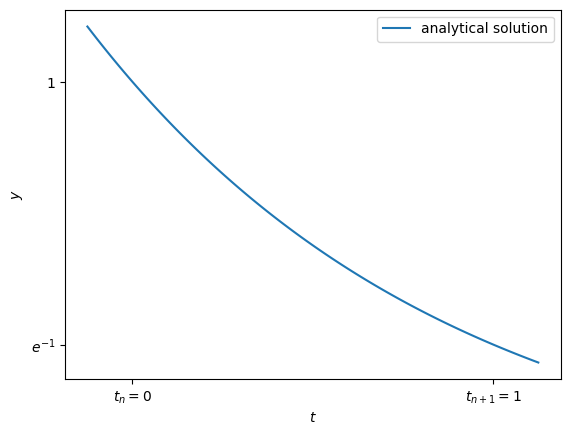

In [2]:
def dydt(t,y): return -y
def y(t) : return np.exp(-t)
y_0 = 1
h = 1
t = np.linspace(0-0.125,h+0.125,100) # extra space for aesthetics
plt.plot(t,y(t),label="analytical solution")
plt.xlabel("$t$")
plt.ylabel("$y$")
plt.xticks([0,1],labels=["$t_n=0$","$t_{n+1}=1$"])
plt.yticks([y(0),y(1)],labels=["1","$e^{-1}$"])
plt.legend()
plt.show()

### (a) RK2 as an average of endpoint derivatives

#### Part 1

The RK2 method uses these update equation :

$$
k_1 = h f(t_n,y_n) \quad -\textcircled{1}\\
k_2 = h f(t_n + h,y_n + k_1) \quad -\textcircled{2}\\
y_{n+1} = y_n + \frac{1}{2}(k_1 + k_2) \quad -\textcircled{3}
$$

Plugging the values of $k_1,k_2$ from equations $\textcircled{1}$ and $\textcircled{2}$ into $\textcircled{3}$ gives us :

$$
y_{n+1} = y_n + \frac{1}{2}(h f(t_n,y_n) + h f(t_n + h,y_n + k_1)) 
\\ = y_n + h \cdot \frac{1}{2}(f(t_n,y_n) + f(t_n + h,y_n + k_1)) 
$$

Now, defining 

$$
f_{n}^{(2)} = \frac{1}{2}(f(t_n,y_n) + f(t_n + h, t_n + k_1))
$$

we can write :

$$
y_{n+1} = y_n + h f_{n}^{(2)}
$$

This is a general equation, not specific to the $f$ given to us currently. 

#### Part 2

To see this visually, let's use the given $f(t,y) = -y$.

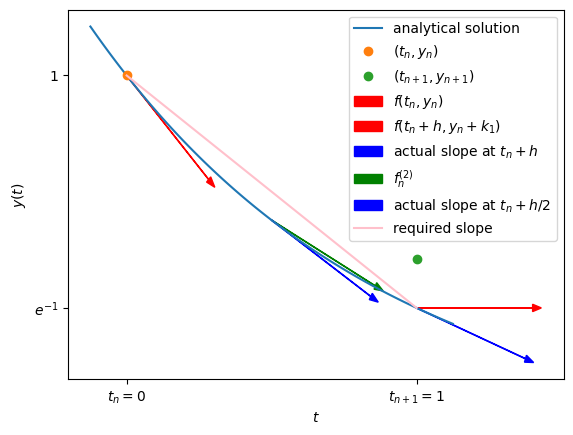

In [3]:
# Exact solution
plt.plot(t,y(t),label="analytical solution")
plt.xlabel("$t$"); plt.ylabel("$y(t)$")
# Marking point
t_n = 0; y_n = y(t_n)
plt.plot(t_n,y_n,'o',label="$(t_n,y_n)$")
# RK2 step
k1 = dydt(t_n,y_n)*h
k2 = dydt(t_n+h,y_n+k1)*h
t_np1 = t_n + h
y_np1 = y_n + (k1+k2)/2
# Marking point
plt.plot(t_np1,y_np1,'o',label="$(t_{n+1},y_{n+1})$")
# drawing arrows 
def draw_arrow(t,m=None,length=0.4,c="red",label=None):
    global y,dydt
    t_1,y_1 = t, y(t)
    if m is None: m = dydt(t_1,y_1)
    Dt,Dy = length * np.array([1,m])/(1+m**2)**0.5
    plt.arrow(t_1,y_1,Dt,Dy,color=c,label=label,head_width=0.02)
    # plt.plot(t_1,y_1,'bo')
draw_arrow(t_n,label="$f(t_n,y_n)$")
draw_arrow(t_n + h, m = dydt(t_n+h,y_n+k1),label="$f(t_n+h,y_n+k_1)$")
draw_arrow(t_n + h, label="actual slope at $t_n + h$",c='blue')
f_2 = (dydt(t_n,y_n) + dydt(t_n+h,y_n+k1))/2
draw_arrow(t_n + h/2, m = f_2,label="$f_n^{(2)}$",c='green')
draw_arrow(t_n + h/2, label="actual slope at $t_n + h/2$",c='blue')
plt.plot([t_n,t_np1],[y_n,y(t_np1)],label = 'required slope',color="pink")
plt.xticks([0,1],labels=["$t_n=0$","$t_{n+1}=1$"])
plt.yticks([y(0),y(1)],labels=["1","$e^{-1}$"])
plt.legend()
plt.show()

### (b) RK4 as a weighted averaged derivative

#### Part 1

For standard RK4, we have these equations :

$$
k_1 = h f(t_n, y_n) \quad - \textcircled{1} \\
k_2 = h f(t_n + h/2, y_n + k_1/2) - \quad \textcircled{2} \\
k_3 = h f(t_n + h/2, y_n + k_2/2) - \quad \textcircled{3} \\
k_4 = h f(t_n + h, y_n + k_3) - \quad \textcircled{4} \\
y_{n+1} = y_n + \frac{k_1}{6} + \frac{k_2}{3} + \frac{k_3}{3} + \frac{k_4}{6} -\quad \textcircled{5}
$$

Plugging the equations $\textcircled{1}$ to $\textcircled{4}$ into equation $\textcircled{5}$ gives us :

$$
Y_{n+1} = y_n + \frac{h}{6} f(t_n, y_n) + \frac{2h}{6} f(t_n + h/2, y_n + k_1/2) + \frac{2h}{6} f(t_n + h, y_n + k_3) + \frac{h}{6} f(t_n + h, y_n + k_3) \\ = 
y_n + h\cdot (\frac{1}{6} f(t_n, y_n) + \frac{1}{3} f(t_n + h/2, y_n + k_1/2) + \frac{1}{3} f(t_n + h, y_n + k_3) + \frac{1}{6} f(t_n + h, y_n + k_3))
$$

Defining 

$$
f_n^{(4)} = \frac{1}{6} f(t_n, y_n) + \frac{1}{3} f(t_n + h/2, y_n + k_1/2) + \frac{1}{3} f(t_n + h, y_n + k_3) + \frac{1}{6} f(t_n + h, y_n + k_3)
$$

we can write :

$$
y_{n+1} = y_{n} + h f_n^{(4)}
$$


#### Part 2

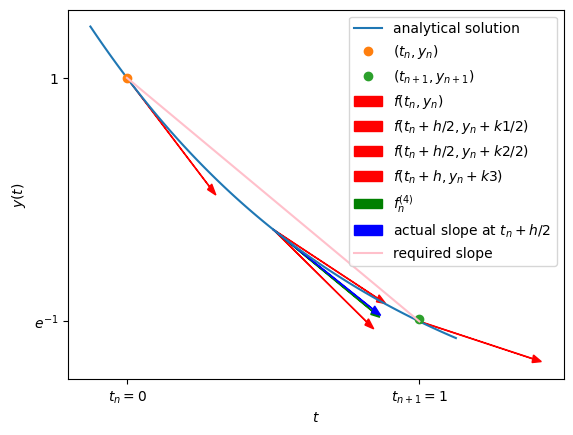

In [4]:
# Exact solution
plt.plot(t,y(t),label="analytical solution")
plt.xlabel("$t$"); plt.ylabel("$y(t)$")
# Marking point
t_n = 0; y_n = y(t_n)
plt.plot(t_n,y_n,'o',label="$(t_n,y_n)$")
# RK2 step
m1 = dydt(t_n,y_n); k1 = m1*h
m2 = dydt(t_n+h/2,y_n+k1/2); k2 = m2*h
m3 = dydt(t_n+h/2,y_n+k2/2); k3 = m3*h
m4 = dydt(t_n+h,y_n+k3); k4 = m4*h
t_np1 = t_n + h
y_np1 = y_n + (k1/6 + k2/3 + k3/3 + k4/6)
# Marking point
plt.plot(t_np1,y_np1,'o',label="$(t_{n+1},y_{n+1})$")
# Drawing arrows
draw_arrow(t_n, m = k1, label="$f(t_n,y_n)$")
draw_arrow(t_n + h/2, m = m2, label="$f(t_n+h/2,y_n+k1/2)$")
draw_arrow(t_n + h/2, m = m3, label="$f(t_n+h/2,y_n+k2/2)$")
draw_arrow(t_n + h, m = m4, label="$f(t_n+h,y_n+k3)$")
f_4 = (m1/6 + m2/3 + m3/3 + m4/6)
draw_arrow(t_n + h/2, m = f_4,label="$f_n^{(4)}$",c='green')
draw_arrow(t_n + h/2, label="actual slope at $t_n + h/2$",c='blue')
plt.plot([t_n,t_np1],[y_n,y(t_np1)],label = 'required slope',color="pink")
plt.xticks([0,1],labels=["$t_n=0$","$t_{n+1}=1$"])
plt.yticks([y(0),y(1)],labels=["1","$e^{-1}$"])
plt.legend()
plt.show()

### (c) : Comparison

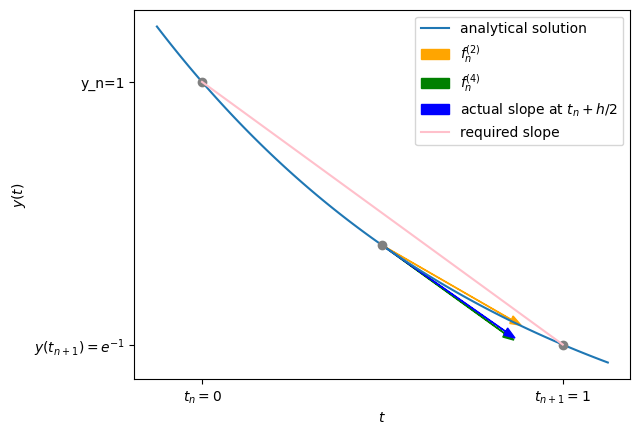

In [5]:
# Exact solution
plt.plot(t,y(t),label="analytical solution")
plt.xlabel("$t$"); plt.ylabel("$y(t)$")
# Marking point
imp_points = np.array([t_n,t_n+h/2,t_np1])
plt.plot(imp_points,y(imp_points),'o',color="gray")
draw_arrow(t_n + h/2, m = f_2,label="$f_n^{(2)}$",c='orange')
draw_arrow(t_n + h/2, m = f_4,label="$f_n^{(4)}$",c='green')
draw_arrow(t_n + h/2, label="actual slope at $t_n + h/2$",c='blue')
plt.plot([t_n,t_np1],[y_n,y(t_np1)],label = 'required slope',color="pink")
plt.xticks([0,1],labels=["$t_n=0$","$t_{n+1}=1$"])
plt.yticks([y(0),y(1)],labels=["y_n=1","$y(t_{n+1})=e^{-1}$"])
plt.legend()
plt.show()

As one can see from the individual figures for analysing the RK4 and RK2 step, 
- Final location $(t_{n+1},y_{n+1})$ is more accurate for RK4 than RK2
- The derivative at $t_n + h/2$ is better approximated by RK4 than RK2. This is not necessary to happen, but is very probable due to Rolle's theorem. 
- The required slope (pink line) is better approximated by RK4.  This is the intended effect, since its this slope that we should update using. It just so happens to also be approximated by the derivative at the mid-point of the step. 

The third fact is because the required slope is actually the average of the true derivatives at each point the curve in the interval $(t_n,t_n+h)$. This derivative is then estimated in RK4 as another average. Do note that the weights in the first infinite average are equal (assuming equally spaced points) but are not equal in RK4. In particular, RK4 gives more weight to estimates that are closer to the midpoint.

The actual reason that RK4 works is of-course because it mimics the taylor series expansion of the function up-to a $h^4$ term.

Now, to answer the questions posed in the lab sheet :

1. There are 4 derivative evaluations, first at $t_n$, and other 3 roughly at $(t_n + h/2),(t_n + h/2),(t_n+h)$. I say "roughly" because the $y$ values used for the derivative evaluations aren't exact, but estimated. 
2. RK4 gives more weight to estimates that are closer to the midpoint.  I don't quite understant what is meant by "shape" here.  

## Problem 2

### Non-linear pendulum ###

We need to solve for 

$$ \ddot \theta = -\frac{g}{l} \sin \theta
$$

which can vectorised to a set of two coupled first-order ODEs:

$$\frac{d}{dt} 
    \begin{bmatrix} \theta \\ \omega \end{bmatrix} = 
    \begin{bmatrix} \omega  \\ -(g/l) \sin \theta \end{bmatrix}
$$

where $\omega = \dot \theta$

We are also given the following **initial condition** at $t=0$,
$$
\begin{bmatrix} \theta \\ \omega \end{bmatrix} = \begin{bmatrix} 0.1 \\ 0.0 \end{bmatrix}.
$$

### (a) Time scale and non-dimensionalization

#### Part 1

Using only dimensional analysis, one can say that $g/l$ has dimensions of $T^{-2}$ and thus the time scale is $T_0 = \sqrt{l/g}$. 
If we instead, compare this to the case where we use the small angle approximation, giving the well known equation $\ddot \theta = - (g/l) \theta$, for which, we know that the fundamental time period is $2\pi \sqrt{\frac{l}{g}} = O(\sqrt{l/g})$, then too, we have $T_0 =\sqrt{l/g}$ as the time scale. 

#### Part 2

By defining $\tau = t/T_0$, we can now write these relations between operators:

$$
\frac{d}{dt} = \frac{1}{T_0} \frac{d}{d\tau} \\
\frac{d^2}{dt^2} = \frac{1}{T_0^2} \frac{d^2}{d\tau^2} = \frac{g}{l} \frac{d^2}{d\tau^2}
$$

Now, we can re-write the original differential equation as :

$$
\frac{d^2}{dt^2}\theta = \frac{g}{l}\frac{d}{d\tau^2}\theta = -\frac{g}{l}\sin\theta \\\implies
\frac{d^2}{d\tau^2}\theta = -\sin\theta 
$$

#### Part 3

Defining $\tilde \omega = \frac{d}{d\tau}\theta = \frac{1}{T_0} \frac{d}{dt}\theta = \frac{1}{T_0}\omega$, we get this vector equation :

$$\frac{d}{d\tau} 
    \begin{bmatrix} \theta \\ \tilde \omega \end{bmatrix} = 
    \begin{bmatrix} \tilde \omega  \\ - \sin \theta \end{bmatrix}
$$

For the remainder of the problem, we will work with this a-dimensionalised vector equation only.

### (b) Numerical Schemes

We define the time after step $n$ as $\tau_n = nh$ where $h$ is the time step. 

We will now implement the Euler and Euler-Cromer methods for the a-dimensionalised differential equation.

The initial values are still $\theta=0.1$ and $\omega=0$ since there is no change in the $\theta$ variable.

Since there is no use of $g$ and $l$, we will not include it. Moreover the time scale for the a-dimensionalised differential equation is just 1. 

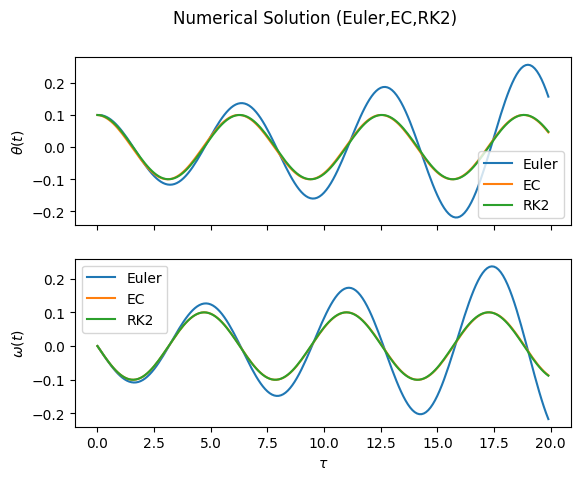

In [6]:
def adimAharmonic(y_0=[0.1,0], **kwargs):
    def dydt(t,y):return np.array([y[1], - np.sin(y[0])])
    return Numerical_Solver(
        y_0,   # initial value
        dydt,  # derivative at t_n, \vec y_n
        tau=1, # time-scale (don't confuse with the time variable tau)
        variable_name=[r"$\theta(t)$",r"$\omega(t)$"],
        **kwargs)

t,res = adimAharmonic(visualise=True, t_max = 20, dt = 0.1, methods = ["Euler","EC","RK2"])
plt.xlabel(r"$\tau$")
plt.show()


### (c) Energy and Phase potrait

The phase potrait can be given as an animation. This is already done by the library I have built. 

In [7]:
t,res,anim = adimAharmonic(visualise="PS", t_max = 7, dt = 0.1, methods = ["Euler","EC","RK2"])
anim

Or, if computational resources are low, we can simply display the path taken, which is what I'll opt to do.

The a-dimensionalised energy is computed as : 

$$
E(\tau) = \frac{1}{2}\omega^2 + (1-\cos\theta)
$$

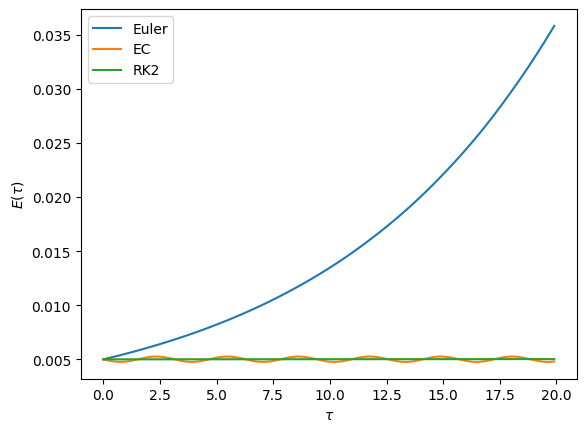

In [8]:
def E(theta,omega): return (omega**2)/2 + (1-np.cos(theta))
def compute_energies(X):
    Energy = {}
    for method in X :
        theta = X[method][:,0] 
        omega = X[method][:,1]
        Energy[method] = E(theta,omega)
    return Energy
t,res = adimAharmonic(visualise=False, t_max = 20, dt = 0.1, methods = ["Euler","EC","RK2"])
Energies = compute_energies(res)
for method in Energies: plt.plot(t, Energies[method],label=method)
plt.legend()
plt.xlabel(r"$\tau$"), plt.ylabel(r"$E(\tau)$")
plt.show()

So, we create a combined function that will do all this plotting for us. 

In [9]:
def PlotFor(y_0=[0.1,0],tau_max=20,h=0.02):
    t,res = adimAharmonic(visualise=True, y_0=y_0, t_max = tau_max, dt = h, methods = ["Euler","EC","RK2"])
    plt.xlabel(r"$\tau$")
    plt.suptitle(r"$\theta=" + str(y_0[0]) + r",\omega=" + str(y_0[1]) + f",h={h}$")
    Energies = compute_energies(res)
    plt.figure()
    plt.title(r"$\theta=" + str(y_0[0]) + r",\omega=" + str(y_0[1]) + f",h={h}$")
    for method in Energies: plt.plot(t, Energies[method],label=method)
    plt.legend()
    plt.xlabel(r"$\tau$"), plt.ylabel(r"$E(\tau)$")
    plt.figure()
    plt.title(r"$\theta=" + str(y_0[0]) + r",\omega=" + str(y_0[1]) + f",h={h}$")
    for method in res: 
        theta = res[method][:,0]
        omega = res[method][:,1]
        plt.plot(theta, omega, '-', label=method)
    plt.plot([y_0[0]],[y_0[1]],'o',label="initial position")
    plt.legend()
    plt.xlabel(r"$\theta(\tau)$")
    plt.ylabel(r"$\omega(\tau)$")

### (d) Tasks

#### Part 1 and 2

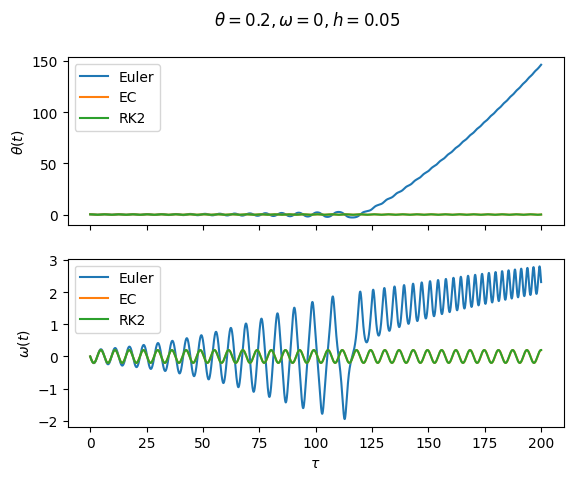

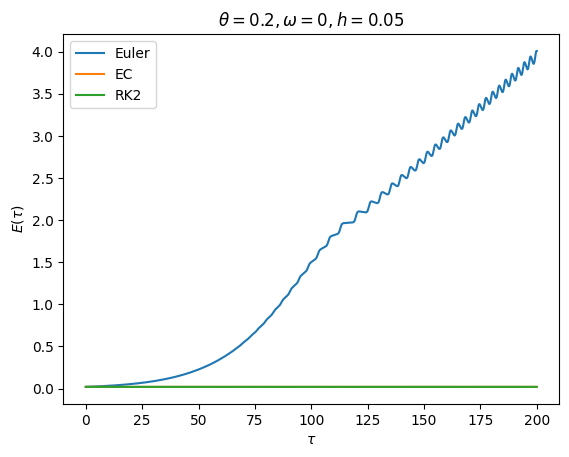

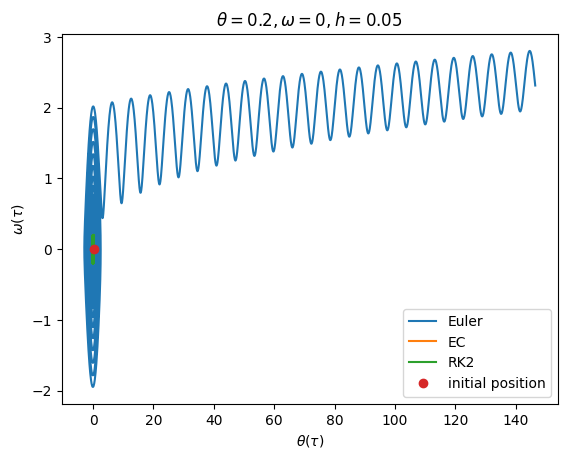

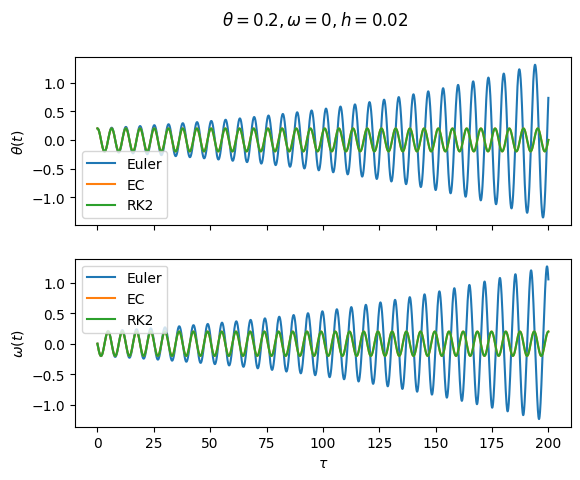

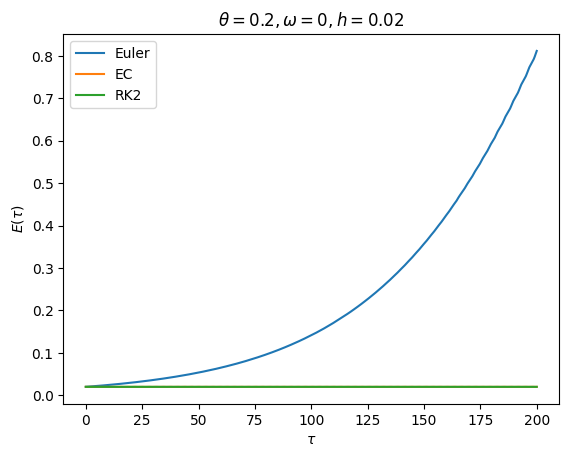

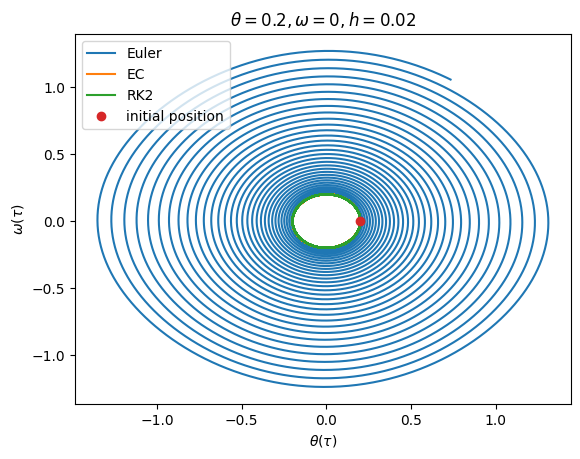

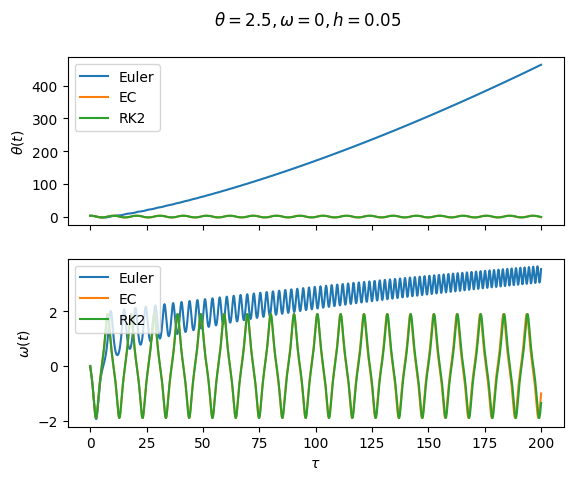

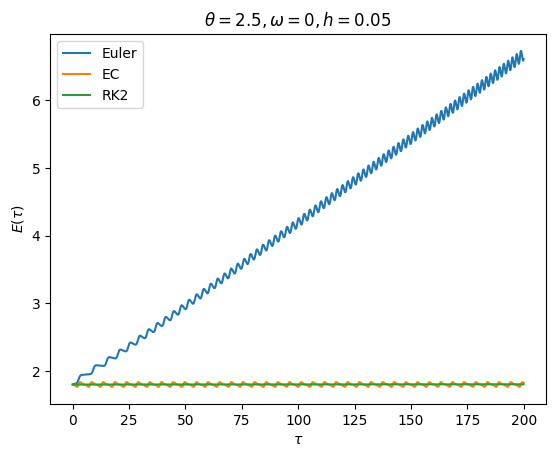

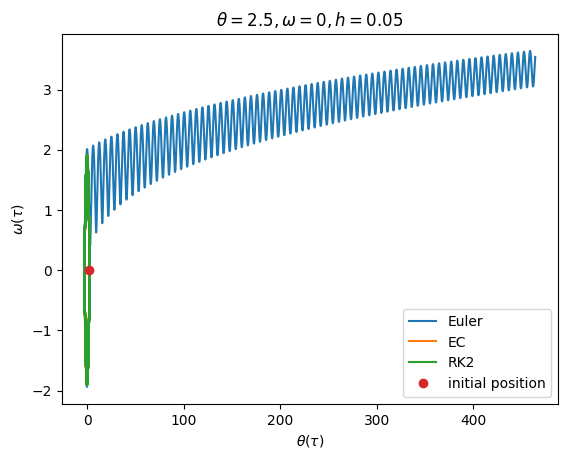

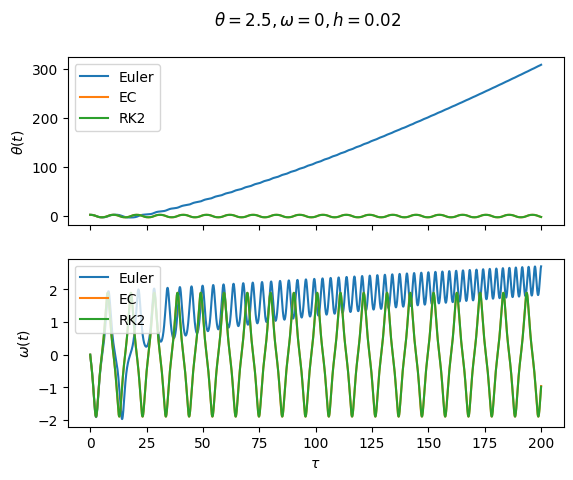

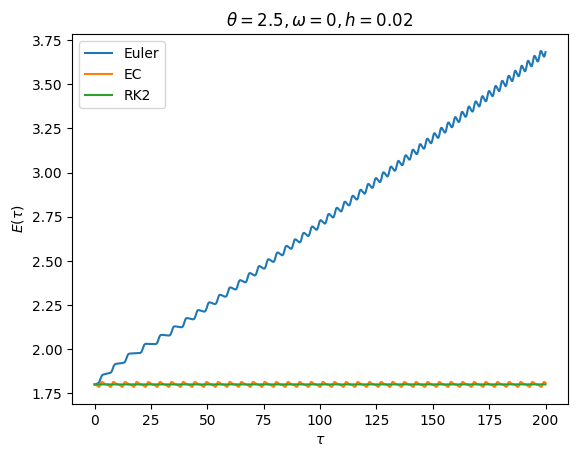

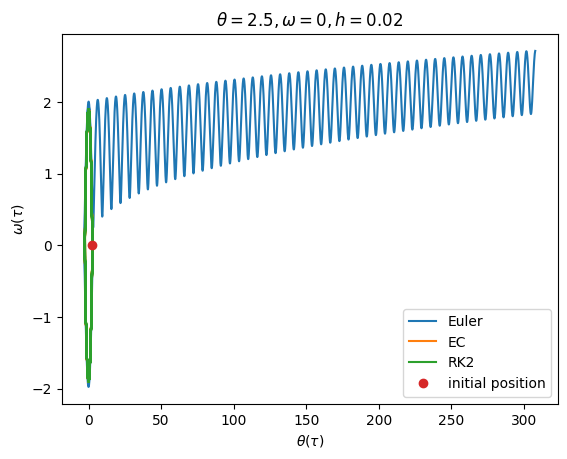

In [10]:
PlotFor([0.2,0], h=0.05, tau_max=200) # theta_0 = 0.2, h=0.05
PlotFor([0.2,0], h=0.02, tau_max=200) # theta_0 = 0.2, h=0.02
PlotFor([2.5,0], h=0.05, tau_max=200) # theta_0 = 2.5, h=0.05
PlotFor([2.5,0], h=0.02, tau_max=200) # theta_0 = 2.5, h=0.02

#### Part 3

For the case with small initial value of $\theta$ (small amplitude), the amplitude of the oscilations slowly increases in case of the numerical solution obtained from Euler's method, whereas this doesn't happen for both RK2 and the Euler-Cromer (EC) method. For RK2, this is because the solution is now much more accurate than before. Whereas, for the EC method, it is due to the energy preserving property of the method. The same can be seen in the graph of $E(\tau)$ vs $\tau$. While there are oscialations in the energy when using the EC method, it isn't exploding like it is for Euler's method. While, with $h=0.02$, the solution from Euler's method only has an increasing amplitude, as can be seen from the phase potrait, for a slightly larger time-step ($h=0.05$), the solution changes its nature and rather than $(\theta(\tau),\omega(\tau))$ having a circular-like motion about the origin, the state is going away from it after some point. Thus, Euler's method doesn't have long term stability. 

To answer the questions asked, I'll summarise quickly :

- EC method has long term stability, wheras Euler's method (and even RK2 method on long timescales) doesn't
- EC method preserves energy and thus the solution cannot go unbounded, wherease Euler's method's solution does go unbounded as we saw
- EC preserves energy (ignoring the very small oscilations in $E(\tau)$) whereas Euler's method has the energy increasing and eventualy going unbounded. 


#### Part 4

To convert back to physical units, we use these transformations :

$$
\omega = \frac{1}{T_0} \tilde \omega = \sqrt{\frac{g}{l}} \tilde \omega,
\quad
t = {T_0} \tau=  \sqrt{\frac{l}{g}} \tau,
\quad 
E = gl \tilde E 
$$

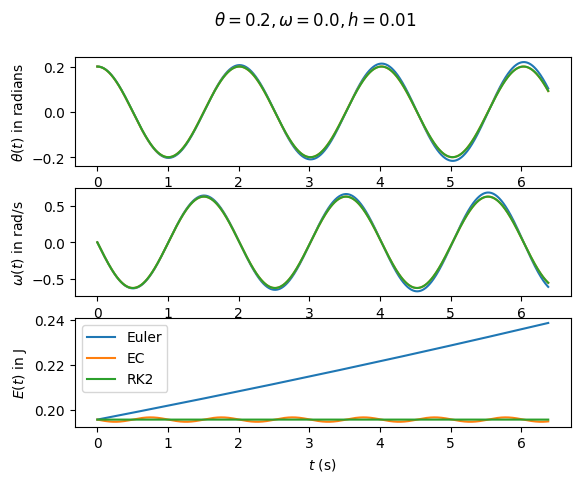

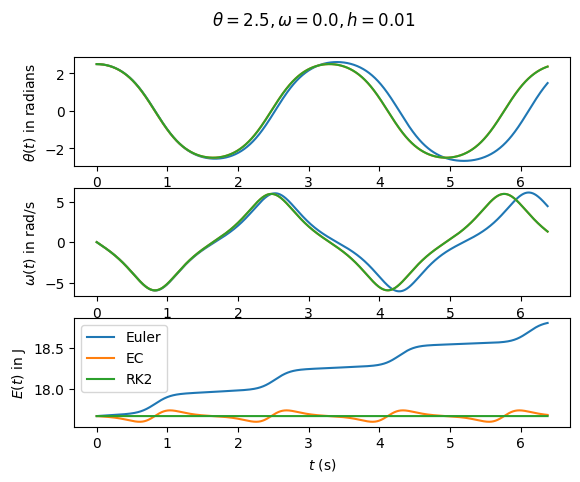

In [28]:

def PlotFor_physical(
    y_0=[
        0.1, # radians
        0 # radians per second
    ],
    l = 1, # meters
    g = 9.81, # ms^-2
    tau_max=20,h=0.01):
    T_0 = (l/g)**0.5 # seconds
    t,res = adimAharmonic(visualise=False, y_0=y_0, t_max = tau_max, dt = h, methods = ["Euler","EC","RK2"])
    t = t * T_0
    for method in res : 
        res[method][:,1] *= (1/T_0)
    plt.figure()
    plt.subplot(3,1,1)
    for method in res : 
        plt.plot(t,res[method][:,0], label=method)
    plt.ylabel(r"$\theta(t)$ in radians")
    plt.subplot(3,1,2)
    for method in res : 
        plt.plot(t,res[method][:,1], label=method)
    plt.ylabel(r"$\omega(t)$ in rad/s")
    plt.subplot(3,1,3)
    for method in res: 
        theta = res[method][:,0]
        omega = res[method][:,1]
        E = g*l*(1-np.cos(theta)) + ((l*omega)**2)/2
        plt.plot(t, E,label=method)
    plt.ylabel(r"$E(t)$ in J")
    plt.xlabel(r"$t$ (s)")
    plt.legend()
    plt.suptitle(r"$\theta=" + str(y_0[0]) + r",\omega=" + str(y_0[1]/T_0) + f",h={h}$")
    # No need to plot the phase potrait this time
    # plt.figure()
    # plt.title(r"$\theta=" + str(y_0[0]) + r",\omega=" + str(y_0[1]) + f",h={h}$")
    # for method in res: 
    #     theta = res[method][:,0]
    #     omega = res[method][:,1]
    #     plt.plot(theta, omega, '-', label=method)
    # plt.plot([y_0[0]],[y_0[1]],'o',label="initial position")
    # plt.legend()
    # plt.xlabel(r"$\theta(t)$ in radians")
    # plt.ylabel(r"$\omega(t)$ in rad/s")

PlotFor_physical(y_0 = [0.2,0])
PlotFor_physical(y_0 = [2.5,0])

For the small amplitude case ($\theta_0 = 0.2$), the time period is close to 2. This is to be expected, since the period of a simple pendulum using small angle approximation is $2\pi T_0$, which has the value of around 2.006 seconds with the given values. 
For the large amplitude case ($\theta_0 = 2.5$), the time period is somewhere between 3 seconds and 3.5 seconds, which is different from the case with small amplitude. 

The reason behind this is that the $2\pi T_0$ value of the time period is derived from the SHM equations after small angle approximation and are not valid in this case. 
The reason that the period increased rather than decreasing is because we have the ineqality $\sin\theta < \theta$ for all $\theta \in \mathbb{R}$. This means that the value of $|\ddot\theta|$ will always be lower than what it would be it the equation were $\ddot \theta = -(g/l) \theta$, and thus the value of $\theta$ will reach $0$ later than the time required in case of very small angles (a fourth the period, namely $\pi T_0/2$) . This is visible in the graphs too. The period is just 4 times this time because of the symmetry that the setup has. 

## Problem 3

### (d) and (e) : Diagnostics and Comparison

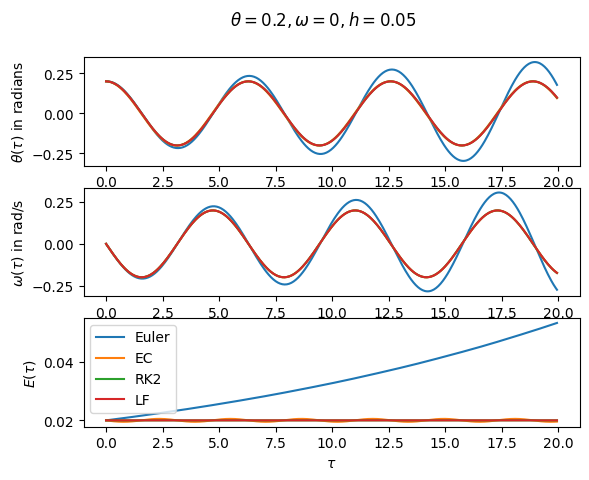

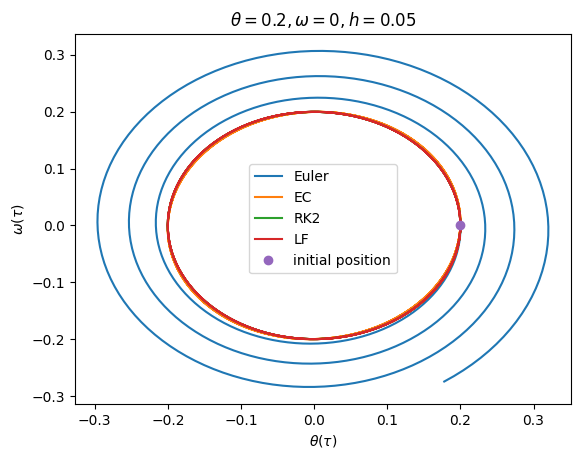

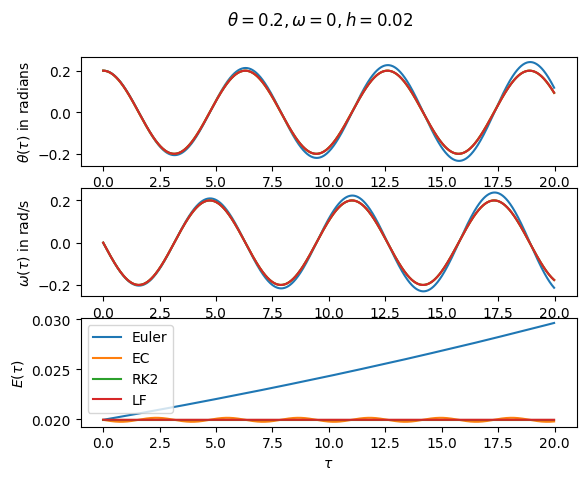

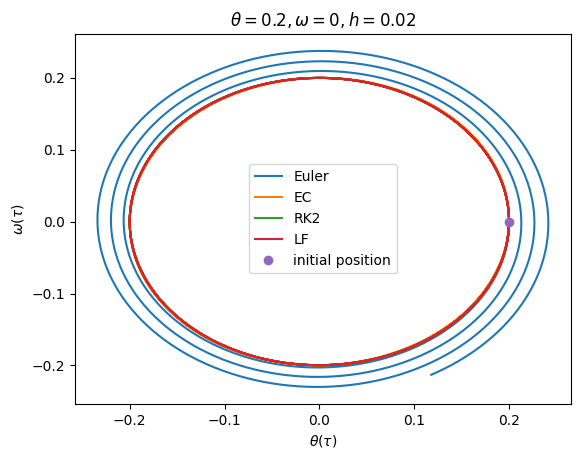

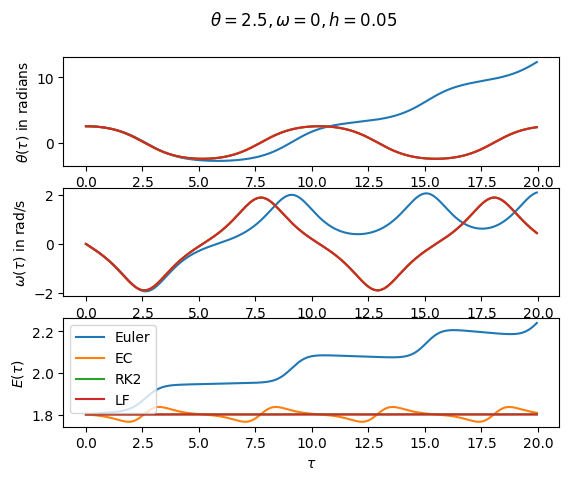

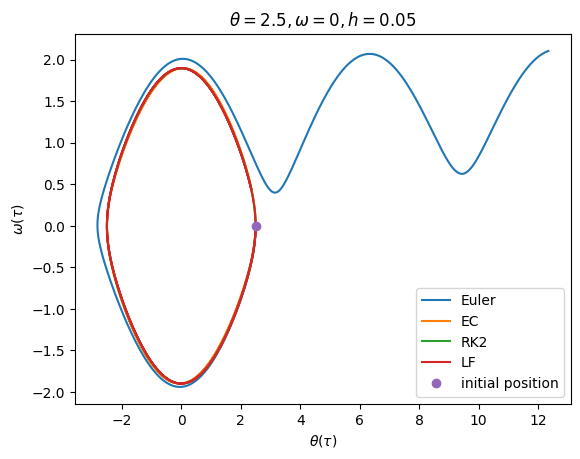

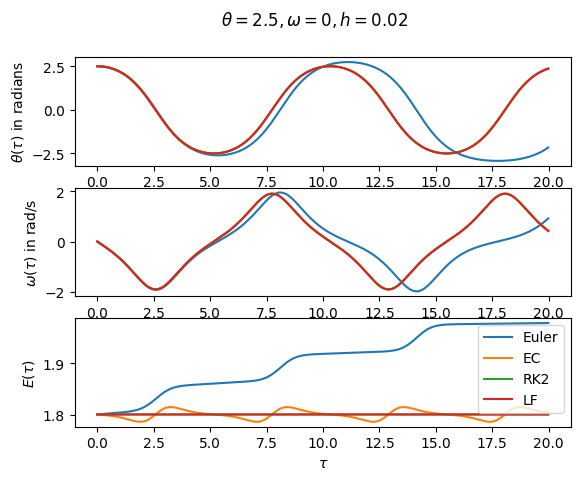

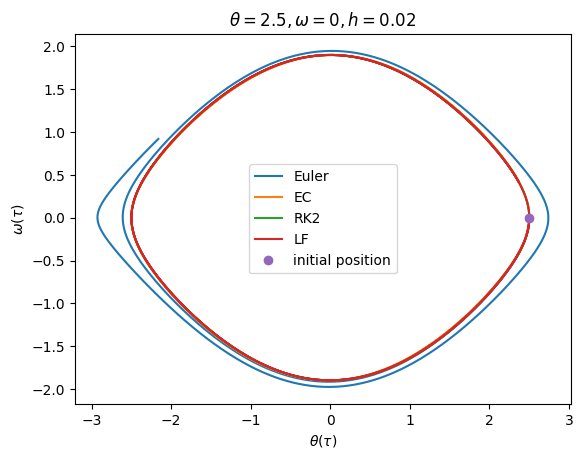

In [45]:
def PlotFor(y_0=[0.1,0],tau_max=20,h=0.02, methods = ["Euler","EC","RK2","LF"]):
    t,res = adimAharmonic(visualise=False, y_0=y_0, t_max = tau_max, dt = h, 
        methods = methods)
    plt.figure()
    plt.subplot(3,1,1)
    for method in res : 
        plt.plot(t,res[method][:,0], label=method)
    plt.ylabel(r"$\theta(\tau)$ in radians")
    # plt.legend() # will have same color scheme, so it's ok
    plt.subplot(3,1,2)
    for method in res : 
        plt.plot(t,res[method][:,1], label=method)
    plt.ylabel(r"$\omega(\tau)$ in rad/s")
    # plt.legend()
    Energies = compute_energies(res)
    plt.subplot(3,1,3)
    for method in Energies: plt.plot(t, Energies[method],label=method)
    plt.legend()
    plt.ylabel(r"$E(\tau)$")
    plt.xlabel(r"$\tau$")
    plt.suptitle(r"$\theta=" + str(y_0[0]) + r",\omega=" + str(y_0[1]) + f",h={h}$")

    plt.figure()
    plt.title(r"$\theta=" + str(y_0[0]) + r",\omega=" + str(y_0[1]) + f",h={h}$")
    for method in res: 
        theta = res[method][:,0]
        omega = res[method][:,1]
        plt.plot(theta, omega, '-', label=method)
    plt.plot([y_0[0]],[y_0[1]],'o',label="initial position")
    plt.legend()
    plt.xlabel(r"$\theta(\tau)$")
    plt.ylabel(r"$\omega(\tau)$")

PlotFor([0.2,0], h=0.05, tau_max=20) # theta_0 = 0.2, h=0.05
PlotFor([0.2,0], h=0.02, tau_max=20) # theta_0 = 0.2, h=0.02
PlotFor([2.5,0], h=0.05, tau_max=20) # theta_0 = 2.5, h=0.05
PlotFor([2.5,0], h=0.02, tau_max=20) # theta_0 = 2.5, h=0.02

As you can see, Euler's method is inaccurate compared to every other method. So, it won't do us good to keep it in the figures, since it eventually goes unbounded and makes it difficult to compare the other methods in the zoomed out plots. 

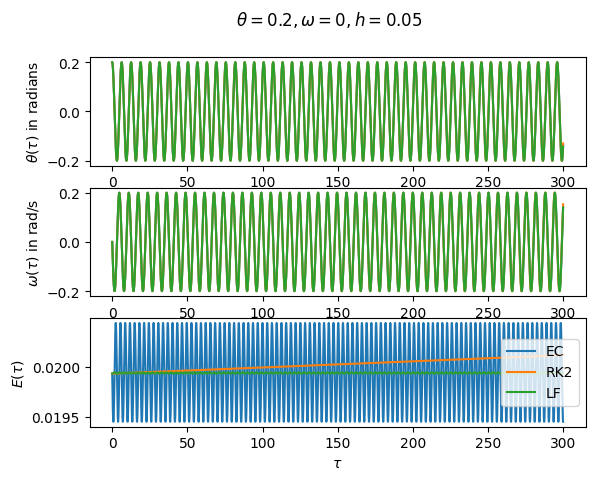

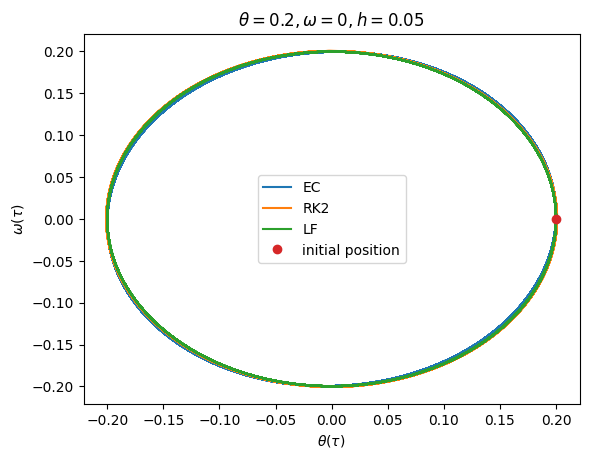

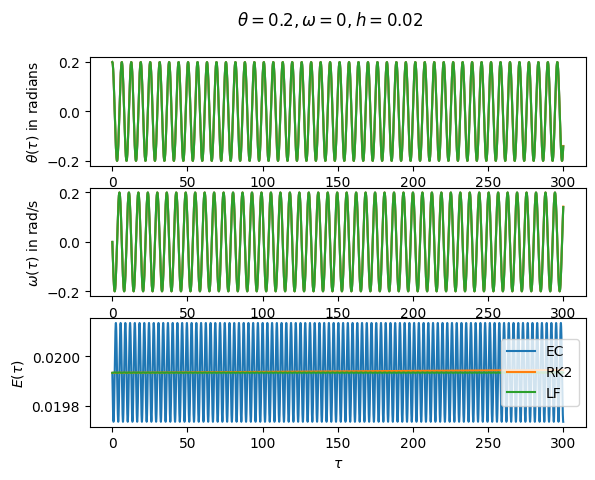

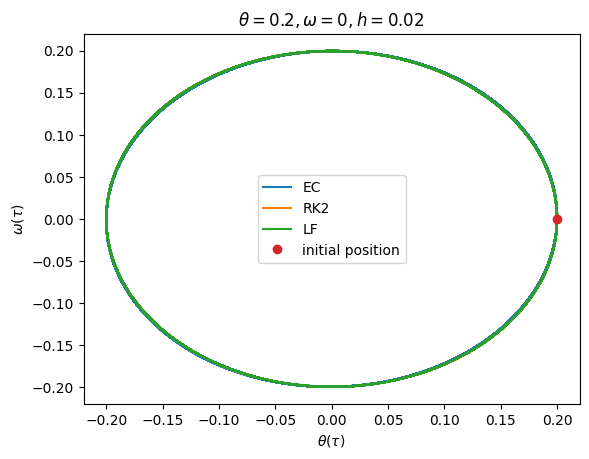

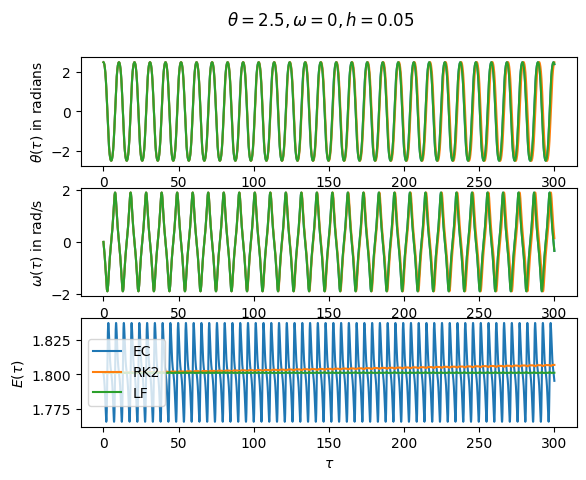

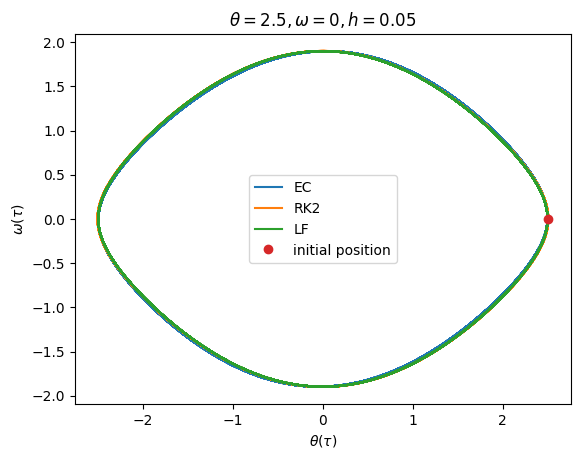

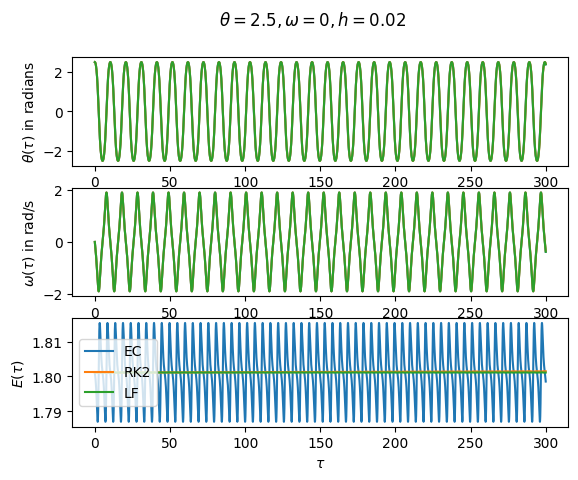

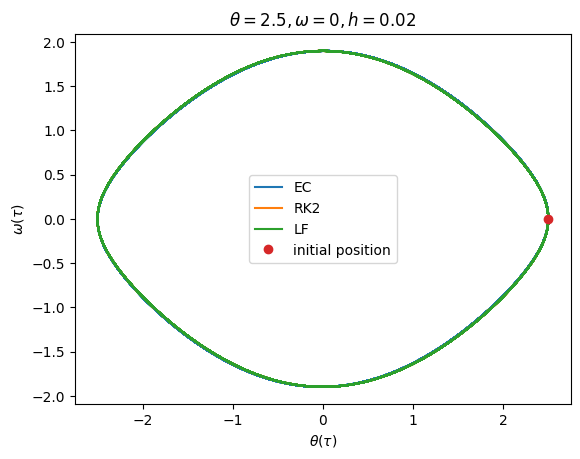

In [50]:
PlotFor([0.2,0], h=0.05, tau_max=300, methods = ["EC","RK2","LF"]) # theta_0 = 0.2, h=0.05
PlotFor([0.2,0], h=0.02, tau_max=300, methods = ["EC","RK2","LF"]) # theta_0 = 0.2, h=0.02
PlotFor([2.5,0], h=0.05, tau_max=300, methods = ["EC","RK2","LF"]) # theta_0 = 2.5, h=0.05
PlotFor([2.5,0], h=0.02, tau_max=300, methods = ["EC","RK2","LF"]) # theta_0 = 2.5, h=0.02

As you can see, all three of these methods are rather accurate, but when we look at the graph for $E(\tau)$, we see that the Leap-Frog (LF) method is not only stable in the long term, unlike RK2 which has an increasing graph (and thus increasing amplitude, which unfortunately is too small for us to visualise) for $E(\tau)$ but is also accurate in the short term and doesn't have the oscilations in $E(\tau)$ that the Euler-Cromer (EC) method has. 

While it's really hard to see, but if you look closely, you'll see that the trajectory in the phase space is going outwards in case of RK2 for $h=0.05$. This is equivalent to the energy increasing. 
Since the effect is really small, we can say that the curve is approximately closed. 
For the two symplectic methods, the curve is also approximately closed. 

While the Leapfrog method has the same formal order ($O(h^2 \tau_\text{max})$ error for final value) of accuracy, it also preserves the energy in every step, which RK2 doesn't do. Thus, while RK2 has an increasing amplitude over long periods, LF doesn't.